## Power spectrum analysis

In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import pandas as pd
import datetime 
from scipy import fftpack
from scipy.stats.distributions import chi2
import xarray as xr

## Functions

In [2]:
def spec(sig,sample_freq,window_type,alpha,**kwargs):
    ##https://www1.udel.edu/biology/rosewc/kaap686/notes/windowing.html
    ## Environmental data analysis with MATLAB-William Menke & Jashua Menke

    ##************************ signal must have even length.************##
    ## window=0 'no window'
    ## window=1 'Hamming window'
    ## window=2 'Hanning window'
    
    N=len(sig)                          #     no of points N
    Dt=sample_freq*1                       # sample frequency /rate
    T=N*Dt;                    
    fmax=1/(2*Dt);                         #     Nyquist (maximum) frequency,
    Df =fmax/(N/2);                        #     frequency interval,
    Nf=N/2+1;                              #     number of non-negative frequencies,#     frequency vector , #f=Df*[0:N/2,-N/2þ1:-1]’; 
    sig=sig-np.mean(sig)
    
    if window_type==1:
        w1=0.54-0.46*np.cos(2*np.pi*np.arange(N)/(N-1)) ## hamming window weight
    elif window_type==2:
        w1=0.5-0.5*np.cos(2*np.pi*np.arange(N)/(N-1)) ## hanning window weight
    else:
        w1=1
    
    signal1=w1*sig
    temp_fft = Dt*sc.fftpack.fft(signal1)
    fftfreq = np.fft.fftfreq(N,Dt)         # daily data it is 1./365 ## monthly data 1./12 ## yearly data=1
    temp_psd = temp_fft*np.conj(temp_fft)*(2/T)
    f = fftfreq[(fftfreq >= 0) |(fftfreq==-fmax)]
    f[-1]=-1*f[-1]
    p = temp_psd[(fftfreq >= 0) | (fftfreq==-fmax)]
    
    #Null Hypothesis: time series is uncorrelated random noise
    sd2est=np.std(sig);                   #   variance of time series,
    ff=np.sum(w1*w1)/N;                        #   power in window function, 
    c = (ff*sd2est)/(2*Nf*Df);               #   scaling constant,  
    cl95 = c*chi2.ppf(1.0-alpha, df=2);           #   95% confidence level,
    
    if len(kwargs)!=0:
        for item,values in kwargs.items():
            ax=values
            ax.plot(1/f,p)
            ax.set_xscale('log')
            ax.axhline(y=cl95,color='r', linestyle='--')
            ax.set_xlabel('Time Period (year)')
            ax.set_ylabel('PSD (dB)')
            ax.grid()

    return p,f,cl95



def theta1_cal( pc1, pc2 ):
    theta1           =  np.zeros(pc2.size)
    angle180         =  np.arctan2(-pc2, -pc1) * 180 / np.pi
    indNeg           =  np.where(angle180<0)[0]
    angle360         = angle180
    angle360[indNeg] = angle180[indNeg] + 360
    theta1           = np.around( ( angle360 + 22.5 ) * 8 / 360 )
    return theta1



def smooth(x,window_len=11,window='hanning'):
    ##https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.
    output:
        the smoothed signal
        
    example:
    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


def lowpass_scipy_butter(signal1,wn,lt):
    from scipy import signal
    w = 2/lt # Normalize the frequency
    b, a = signal.butter(wn, w, 'low')
    lowpass_signal = signal.filtfilt(b, a, signal1)

    return lowpass_signal

def lowpass_scipy(signal,sample_freq,time_period,keep_mean):
    import numpy as np
    import scipy as sc
    from scipy import fftpack
    
    lowpass_signal=np.zeros(signal.shape)
    if any(np.isnan(signal)):
        raise ValueError('There is NaN in the signal')
    else:
        hf = 1./time_period

        temp_fft = sc.fftpack.fft(signal)

        fftfreq = np.fft.fftfreq(len(signal),sample_freq) ### daily data it is 1./365 ## monthly data 1./12 ## yearly data=1
          
        i1 = np.abs(fftfreq) >= hf  
        
        temp_fft[i1] = 0
        if not(keep_mean):
            temp_fft[0]=0
        lowpass_signal= np.real_if_close(sc.fftpack.ifft(temp_fft))
    
    return lowpass_signal
def seas_separate(d11,d22,s_year,e_year):
    d11_temp=d11.loc[str(s_year)+'-11-01':str(e_year)+'-04-30']
    d22_temp=d22.loc[str(s_year)+'-11-01':str(e_year)+'-04-30']
    return d11_temp,d22_temp


def ave_power(d11,d22,st1,en1):
    
    N = en1-st1
    power_1= np.zeros((91,N))
    power_2= np.zeros((91,N))
    max_period1 =np.zeros(N,)
    max_period2 =np.zeros(N,)
    
    for i in np.arange(st1,en1,1):
        
        d11_temp,d22_temp = seas_separate(d11,d22,i,i+1)
        
        p1,f1,cl95 = spec(d11_temp.values.squeeze()[0:181],sample_freq=1,window_type='hanning',alpha=0.5)
        p2,f2,cl95 = spec(d22_temp.values.squeeze()[0:181],sample_freq=1,window_type='hanning',alpha=0.5)
        
        T= 1/f1
        
        p11 = p1*1
        p11[T>100] =0
        
        p22 = p2*1
        p22[T>100] =0
        
        max_period1[i-st1] = T[p11==np.max(p11)]
        max_period2[i-st1] = T[p22==np.max(p22)]

        power_1[:,i-st1]= p1
        power_2[:,i-st1]= p2
    
    ave_power1 = np.mean(power_1,axis=1) 
    ave_power2 = np.mean(power_2,axis=1) 
    T= 1/f1
    return T,ave_power1,ave_power2,max_period1,max_period2

## ALL

In [3]:
st = 1979 ; en = 2015 ;lf = 10;wn = 3
n = en-st;    
rmm = xr.open_dataset('RMM_WH04_index_new.nc')
rmm1 = rmm['PC1'].loc[str(st)+'-01-01':str(en)+'-12-31']
rmm2 = rmm['PC2'].loc[str(st)+'-01-01':str(en)+'-12-31']

amp1_wh04 = rmm['MJO_INDEX']
phase1_wh04 = theta1_cal( rmm1, rmm2 )



# rm11 = np.real(lowpass_scipy(rmm1.values,sample_freq=1,time_period=10,keep_mean=1))
rm11 = lowpass_scipy_butter(rmm1.values,wn,lf)
rmm11 = pd.Series(rm11,index  = rmm1.time.values,name='rmm1').to_frame()

# rm22 = np.real(lowpass_scipy(rmm2.values,sample_freq=1,time_period=10,keep_mean=1))
rm22 = lowpass_scipy_butter(rmm2.values,wn,lf)
rmm22 = pd.Series(rm22,index  = rmm2.time.values,name='rmm2').to_frame()


In [4]:
st = 1905 ; en = 2015
############################################# conv ######################################################################
df11 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/conv1d/ensamble4/ensamble_conv1d_jgrjd_rmm1_p1.csv')

df11.columns = ['Datetime','rmm1']
df11.index = pd.to_datetime(df11.Datetime)
df11_conv = df11.drop('Datetime',axis=1)


df22 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/conv1d/ensamble4/ensamble_conv1d_jgrjd_rmm2.csv')

df22.columns = ['Datetime','rmm2']
df22.index = pd.to_datetime(df22.Datetime)
df22_conv = df22.drop('Datetime',axis=1)

d1_conv_hist = df11_conv[(df11_conv.index >= datetime.datetime(st,1,1)) & (df11_conv.index  <= datetime.datetime(en,12,31))]
d2_conv_hist = df22_conv[(df22_conv.index >= datetime.datetime(st,1,1)) & (df22_conv.index  <= datetime.datetime(en,12,31))]




############################################## ol ##############################################################################################

df2 = pd.read_csv('/home/cccr/supriyo/panini/data/rmm_oliver_V3.csv')
df2['Datetime'] = df2.year.map(str) + '-' + df2.month.map(str) + '-'+df2.day.map(str) 
df2.index = pd.to_datetime(df2.Datetime)
df2 = df2.drop('Datetime',axis=1)
df2['IHR1'] = df2[['IHR1']]/df2['IHR1'].loc['1979-01-01':'2008-12-31'].std()
df2['IHR2'] = df2[['IHR2']]/df2['IHR2'].loc['1979-01-01':'2008-12-31'].std()


d1_ol = df2[(df2.index >= datetime.datetime(st,1,1)) & (df2.index  <= datetime.datetime(en,12,31))]
d2_ol = df2[(df2.index >= datetime.datetime(st,1,1)) & (df2.index  <= datetime.datetime(en,12,31))]



########################################### JRA 55 ###########################################################################

stj = 1958;enj=2015;nj=enj-stj
df_jra55 = pd.read_excel('/home/cccr/supriyo/panini/filtered_data/data/jra55_mjo_index.xlsx')
df_jra55['Datetime'] = df_jra55.year.map(str) + '-' + df_jra55.month.map(str) + '-'+df_jra55.day.map(str) 
df_jra55.index = pd.to_datetime(df_jra55.Datetime)
df_jra55 = df_jra55.drop('Datetime',axis=1)

df_jra55['rmm1'] = df_jra55[['rmm1']]/df_jra55['rmm1'].loc['1979-01-01':'2008-12-31'].std()
df_jra55['rmm2'] = df_jra55[['rmm2']]/df_jra55['rmm2'].loc['1979-01-01':'2008-12-31'].std()

d1_jra = df_jra55[(df_jra55.index >= datetime.datetime(stj,1,1)) & (df_jra55.index  <= datetime.datetime(enj,12,31))]
d2_jra = df_jra55[(df_jra55.index >= datetime.datetime(stj,1,1)) & (df_jra55.index  <= datetime.datetime(enj,12,31))]


################################################# mlr ###################################################################

df11 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/multiple_regression/rmm1_MLR_org.txt')

df11.columns = ['Datetime','rmm1']
df11.index = pd.to_datetime(df11.Datetime)
df11 = df11.drop('Datetime',axis=1)
df11 = df11[['rmm1']]/df11['rmm1'].loc['1979-01-01':'2008-12-31'].std()


df22 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/multiple_regression/rmm2_MLR_org.txt')
df22.columns = ['Datetime','rmm2']
df22.index = pd.to_datetime(df22.Datetime)
df22 = df22.drop('Datetime',axis=1)
df22 = df22[['rmm2']]/df22['rmm2'].loc['1979-01-01':'2008-12-31'].std()


d1_mlr = df11[(df11.index >= datetime.datetime(st,1,1)) & (df11.index  <= datetime.datetime(en,12,31))]
d2_mlr = df22[(df22.index >= datetime.datetime(st,1,1)) & (df22.index  <= datetime.datetime(en,12,31))]


###################################################### svr #########################################################
df_svr11 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/SVR/rmm1_1905_2015_svr_org_new.txt')

df_svr11.columns = ['Datetime','rmm1']
df_svr11.index = pd.to_datetime(df_svr11.Datetime)
df_svr11 = df_svr11.drop('Datetime',axis=1)
df_svr11 = df_svr11[['rmm1']]/df_svr11['rmm1'].loc['1979-01-01':'2008-12-31'].std()


df_svr22 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/SVR/rmm2_1905_2015_svr_org_new.txt')
df_svr22.columns = ['Datetime','rmm2']
df_svr22.index = pd.to_datetime(df_svr22.Datetime)
df_svr22 = df_svr22.drop('Datetime',axis=1)
df_svr22 = df_svr22[['rmm2']]/df_svr22['rmm2'].loc['1979-01-01':'2008-12-31'].std()


d1_svr = df_svr11[(df_svr11.index >= datetime.datetime(st,1,1)) & (df_svr11.index  <= datetime.datetime(en,12,31))]
d2_svr = df_svr22[(df_svr22.index >= datetime.datetime(st,1,1)) & (df_svr22.index  <= datetime.datetime(en,12,31))]



######################################### c2d ############################################################################
df11 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/deep_CNN/rmm1_conv_minmaxscale_1905_2015.csv')

df11.columns = ['Datetime','rmm1']
df11.index = pd.to_datetime(df11.Datetime)
df11_c2d = df11.drop('Datetime',axis=1)
df11_c2d = df11_c2d[['rmm1']]/df11_c2d['rmm1'].loc['1979-01-01':'2008-12-31'].std()



df22 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/deep_CNN/rmm2_conv_minmaxscale_1905_2015.csv')

df22.columns = ['Datetime','rmm2']
df22.index = pd.to_datetime(df22.Datetime)
df22_c2d = df22.drop('Datetime',axis=1)
df22_c2d = df22_c2d[['rmm2']]/df22_c2d['rmm2'].loc['1979-01-01':'2008-12-31'].std()


d1_c2d_hist = df11_c2d[(df11_c2d.index >= datetime.datetime(st,1,1)) & (df11_c2d.index  <= datetime.datetime(en,12,31))]
d2_c2d_hist = df22_c2d[(df22_c2d.index >= datetime.datetime(st,1,1)) & (df22_c2d.index  <= datetime.datetime(en,12,31))]



In [5]:
st1 = 1921 ; en1 = 1944 ; st2 =1945 ;en2 =1976;st3 =1977;en3 =2005;st4 =2006;en4 =2012;
n = en1-st1;   

In [6]:
## conv ###
T,pow1_conv,_,_,_= ave_power(d1_conv_hist['rmm1'],d2_conv_hist['rmm2'],st1,en1)
T,pow2_conv,_,_,_ = ave_power(d1_conv_hist['rmm1'],d2_conv_hist['rmm2'],st2,en2)
T,pow3_conv,_,_,_ = ave_power(d1_conv_hist['rmm1'],d2_conv_hist['rmm2'],st3,en3)
T,pow4_conv,_,_,_ = ave_power(d1_conv_hist['rmm1'],d2_conv_hist['rmm2'],st4,en4)
## ol ###
T,pow1_ol,_,_,_ = ave_power(d1_ol['IHR1'],d2_ol['IHR2'],st1,en1)
T,pow2_ol,_,_,_ = ave_power(d1_ol['IHR1'],d2_ol['IHR2'],st2,en2)
T,pow3_ol,_,_,_ = ave_power(d1_ol['IHR1'],d2_ol['IHR2'],st3,en3)
T,pow4_ol,_,_,_ = ave_power(d1_ol['IHR1'],d2_ol['IHR2'],st4,en4)

## wh04 ###
T,pow3_wh04,_,_,_ = ave_power(rmm11['rmm1'],rmm22['rmm2'],1979,en3)
T,pow4_wh04,_,_,_ = ave_power(rmm11['rmm1'],rmm22['rmm2'],st4,en4)

## mlr ###
T,pow1_mlr,_,_,_ = ave_power(d1_mlr['rmm1'],d2_mlr['rmm2'],st1,en1)
T,pow2_mlr,_,_,_ = ave_power(d1_mlr['rmm1'],d2_mlr['rmm2'],st2,en2)
T,pow3_mlr,_,_,_ = ave_power(d1_mlr['rmm1'],d2_mlr['rmm2'],st3,en3)
T,pow4_mlr,_,_,_ = ave_power(d1_mlr['rmm1'],d2_mlr['rmm2'],st4,en4)
## svr ###
T,pow1_svr,_,_,_ = ave_power(d1_svr['rmm1'],d2_svr['rmm2'],st1,en1)
T,pow2_svr,_,_,_ = ave_power(d1_svr['rmm1'],d2_svr['rmm2'],st2,en2)
T,pow3_svr,_,_,_ = ave_power(d1_svr['rmm1'],d2_svr['rmm2'],st3,en3)
T,pow4_svr,_,_,_ = ave_power(d1_svr['rmm1'],d2_svr['rmm2'],st4,en4)
## jra ###
T,pow2_jra,_,_,_ = ave_power(d1_jra['rmm1'],d2_jra['rmm2'],1959,en2)
T,pow3_jra,_,_,_ = ave_power(d1_jra['rmm1'],d2_jra['rmm2'],st3,en3)
T,pow4_jra,_,_,_= ave_power(d1_jra['rmm1'],d2_jra['rmm2'],st4,en4)

/home/cccr/supriyo/.conda/envs/environment1/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in true_divide
/home/cccr/supriyo/.conda/envs/environment1/lib/python3.7/site-packages/ipykernel_launcher.py:183: ComplexWarning: Casting complex values to real discards the imaginary part
/home/cccr/supriyo/.conda/envs/environment1/lib/python3.7/site-packages/ipykernel_launcher.py:184: ComplexWarning: Casting complex values to real discards the imaginary part
/home/cccr/supriyo/.conda/envs/environment1/lib/python3.7/site-packages/ipykernel_launcher.py:188: RuntimeWarning: divide by zero encountered in true_divide


Text(0, 0.5, 'Power')

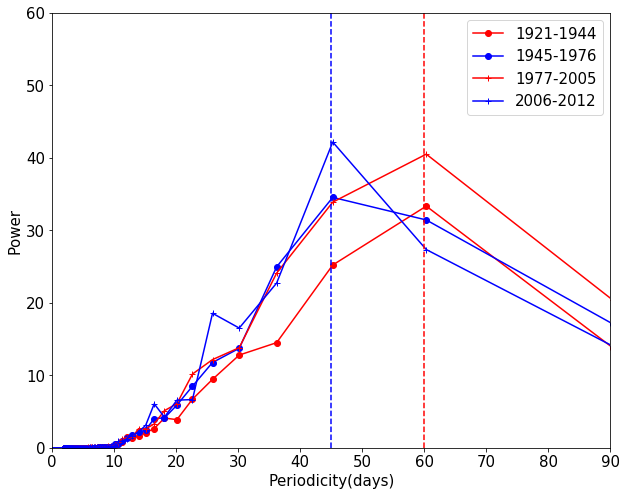

In [7]:
plt.figure(figsize=(10,8))
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 15
plt.rcParams['image.cmap'] = 'seismic'


pow1_rmm1 = np.mean(np.array([pow1_conv,pow1_ol,pow1_svr,pow1_mlr]).T,axis=1)
pow2_rmm1 = np.mean(np.array([pow2_conv,pow2_ol,pow2_svr,pow2_mlr]).T,axis=1)
pow3_rmm1 = np.mean(np.array([pow3_conv,pow3_ol,pow3_svr,pow3_mlr,pow3_jra,pow3_wh04]).T,axis=1)
pow4_rmm1 = np.mean(np.array([pow4_conv,pow4_ol,pow4_svr,pow4_mlr,pow3_jra,pow4_wh04]).T,axis=1)

plt.plot(T,pow1_rmm1,'ro-',label=str(st1)+'-'+str(en1))
plt.plot(T,pow2_rmm1,'bo-',label=str(st2)+'-'+str(en2))
plt.plot(T,pow3_rmm1,'r+-',label=str(st3)+'-'+str(en3))
plt.plot(T,pow4_rmm1,'b+-',label=str(st4)+'-'+str(en4))



plt.xlim([0,90])
plt.ylim([0,60])

plt.legend()
plt.axvline(45,linestyle='--',color='b')
plt.axvline(60,linestyle='--',color='r')


plt.xlabel('Periodicity(days)')
plt.ylabel('Power')

# plt.savefig('/home/cccr/supriyo/panini/jgrjd_figure_9.png',dpi=1200,bbox_inches='tight')

## RMM2

In [8]:
## conv ###
T,_,pow1_conv,_,_= ave_power(d1_conv_hist['rmm1'],d2_conv_hist['rmm2'],st1,en1)
T,_,pow2_conv,_,_ = ave_power(d1_conv_hist['rmm1'],d2_conv_hist['rmm2'],st2,en2)
T,_,pow3_conv,_,_ = ave_power(d1_conv_hist['rmm1'],d2_conv_hist['rmm2'],st3,en3)
T,_,pow4_conv,_,_ = ave_power(d1_conv_hist['rmm1'],d2_conv_hist['rmm2'],st4,en4)
## ol ###
T,_,pow1_ol,_,_ = ave_power(d1_ol['IHR1'],d2_ol['IHR2'],st1,en1)
T,_,pow2_ol,_,_ = ave_power(d1_ol['IHR1'],d2_ol['IHR2'],st2,en2)
T,_,pow3_ol,_,_ = ave_power(d1_ol['IHR1'],d2_ol['IHR2'],st3,en3)
T,_,pow4_ol,_,_ = ave_power(d1_ol['IHR1'],d2_ol['IHR2'],st4,en4)

## wh04 ###
T,_,pow3_wh04,_,_ = ave_power(rmm11['rmm1'],rmm22['rmm2'],1979,en3)
T,_,pow4_wh04,_,_ = ave_power(rmm11['rmm1'],rmm22['rmm2'],st4,en4)

## mlr ###
T,_,pow1_mlr,_,_ = ave_power(d1_mlr['rmm1'],d2_mlr['rmm2'],st1,en1)
T,_,pow2_mlr,_,_ = ave_power(d1_mlr['rmm1'],d2_mlr['rmm2'],st2,en2)
T,_,pow3_mlr,_,_ = ave_power(d1_mlr['rmm1'],d2_mlr['rmm2'],st3,en3)
T,_,pow4_mlr,_,_ = ave_power(d1_mlr['rmm1'],d2_mlr['rmm2'],st4,en4)
## svr ###
T,_,pow1_svr,_,_ = ave_power(d1_svr['rmm1'],d2_svr['rmm2'],st1,en1)
T,_,pow2_svr,_,_ = ave_power(d1_svr['rmm1'],d2_svr['rmm2'],st2,en2)
T,_,pow3_svr,_,_ = ave_power(d1_svr['rmm1'],d2_svr['rmm2'],st3,en3)
T,_,pow4_svr,_,_ = ave_power(d1_svr['rmm1'],d2_svr['rmm2'],st4,en4)
## jra ###
T,_,pow2_jra,_,_ = ave_power(d1_jra['rmm1'],d2_jra['rmm2'],1959,en2)
T,_,pow3_jra,_,_ = ave_power(d1_jra['rmm1'],d2_jra['rmm2'],st3,en3)
T,_,pow4_jra,_,_= ave_power(d1_jra['rmm1'],d2_jra['rmm2'],st4,en4)

/home/cccr/supriyo/.conda/envs/environment1/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in true_divide
/home/cccr/supriyo/.conda/envs/environment1/lib/python3.7/site-packages/ipykernel_launcher.py:183: ComplexWarning: Casting complex values to real discards the imaginary part
/home/cccr/supriyo/.conda/envs/environment1/lib/python3.7/site-packages/ipykernel_launcher.py:184: ComplexWarning: Casting complex values to real discards the imaginary part
/home/cccr/supriyo/.conda/envs/environment1/lib/python3.7/site-packages/ipykernel_launcher.py:188: RuntimeWarning: divide by zero encountered in true_divide


Text(0, 0.5, 'Power')

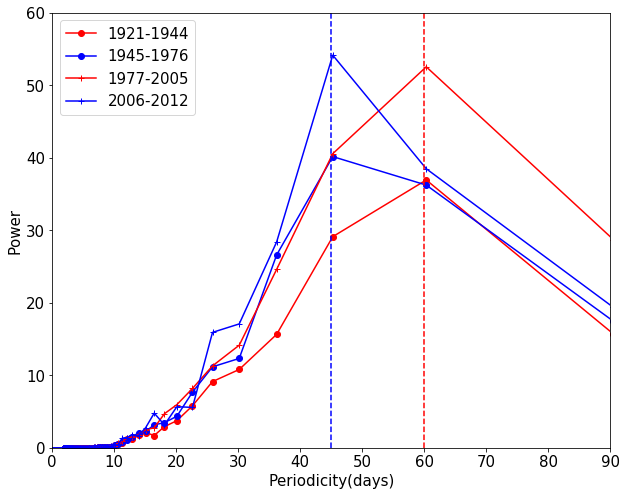

In [9]:
plt.figure(figsize=(10,8))
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 15
plt.rcParams['image.cmap'] = 'seismic'


pow1_rmm2= np.mean(np.array([pow1_conv,pow1_ol,pow1_svr,pow1_mlr]).T,axis=1)
pow2_rmm2 = np.mean(np.array([pow2_conv,pow2_ol,pow2_svr,pow2_mlr]).T,axis=1)
pow3_rmm2 = np.mean(np.array([pow3_conv,pow3_ol,pow3_svr,pow3_mlr,pow3_jra,pow3_wh04]).T,axis=1)
pow4_rmm2 = np.mean(np.array([pow4_conv,pow4_ol,pow4_svr,pow4_mlr,pow3_jra,pow4_wh04]).T,axis=1)

plt.plot(T,pow1_rmm2,'ro-',label=str(st1)+'-'+str(en1))
plt.plot(T,pow2_rmm2,'bo-',label=str(st2)+'-'+str(en2))
plt.plot(T,pow3_rmm2,'r+-',label=str(st3)+'-'+str(en3))
plt.plot(T,pow4_rmm2,'b+-',label=str(st4)+'-'+str(en4))



plt.xlim([0,90])
plt.ylim([0,60])

plt.legend()
plt.axvline(45,linestyle='--',color='b')
plt.axvline(60,linestyle='--',color='r')
plt.xlabel('Periodicity(days)')
plt.ylabel('Power')


## RMM1 and RMM2 together

In [10]:
%store pow1_rmm1 
%store pow2_rmm1
%store pow3_rmm1
%store pow4_rmm1
%store pow1_rmm2 
%store pow2_rmm2
%store pow3_rmm2
%store pow4_rmm2
%store T

Stored 'pow1_rmm1' (ndarray)
Stored 'pow2_rmm1' (ndarray)
Stored 'pow3_rmm1' (ndarray)
Stored 'pow4_rmm1' (ndarray)
Stored 'pow1_rmm2' (ndarray)
Stored 'pow2_rmm2' (ndarray)
Stored 'pow3_rmm2' (ndarray)
Stored 'pow4_rmm2' (ndarray)
Stored 'T' (ndarray)


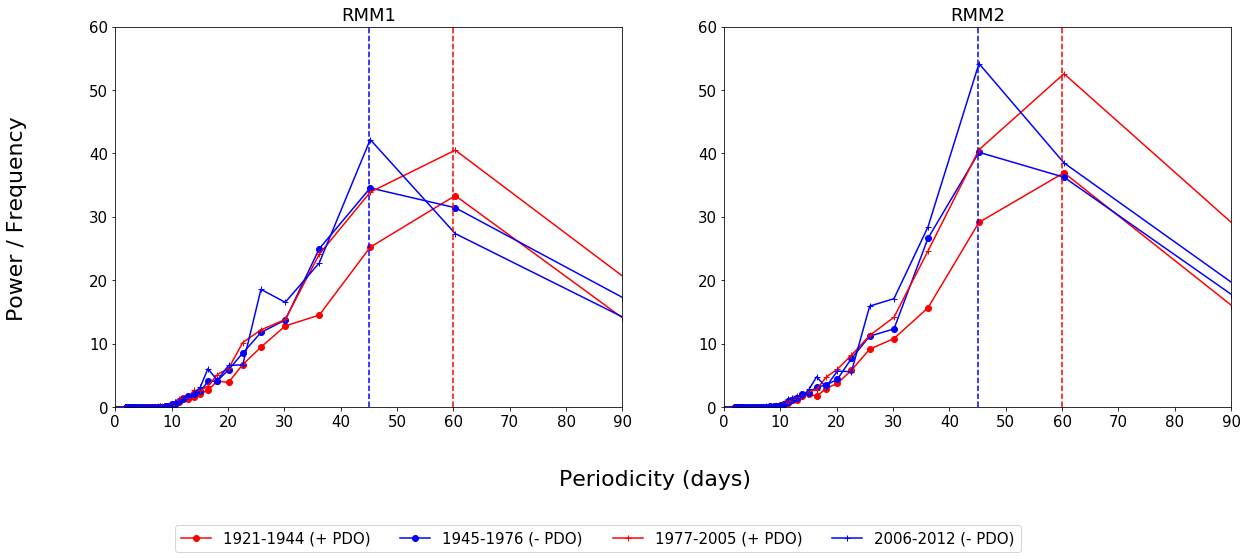

In [11]:
fig,ax  = plt.subplots(1,2,figsize=(20,7))
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 15
plt.rcParams['image.cmap'] = 'seismic'


ax[0].plot(T,pow1_rmm1,'ro-',label=str(st1)+'-'+str(en1)+' (+ PDO)')
ax[0].plot(T,pow2_rmm1,'bo-',label=str(st2)+'-'+str(en2)+' (- PDO)')
ax[0].plot(T,pow3_rmm1,'r+-',label=str(st3)+'-'+str(en3)+' (+ PDO)')
ax[0].plot(T,pow4_rmm1,'b+-',label=str(st4)+'-'+str(en4)+' (- PDO)')
ax[1].plot(T,pow1_rmm2,'ro-',label=str(st1)+'-'+str(en1)+' (+ PDO)')
ax[1].plot(T,pow2_rmm2,'bo-',label=str(st2)+'-'+str(en2)+' (- PDO)')
ax[1].plot(T,pow3_rmm2,'r+-',label=str(st3)+'-'+str(en3)+' (+ PDO)')
ax[1].plot(T,pow4_rmm2,'b+-',label=str(st4)+'-'+str(en4)+' (- PDO)')

ax[0].set_title('RMM1')
ax[1].set_title('RMM2')

ax[0].set_xlim([0,90])
ax[0].set_ylim([0,60])
ax[1].set_xlim([0,90])
ax[1].set_ylim([0,60])
ax[0].axvline(45,linestyle='--',color='b')
ax[0].axvline(60,linestyle='--',color='r')
ax[1].axvline(45,linestyle='--',color='b')
ax[1].axvline(60,linestyle='--',color='r')
# ax[0].set_ylabel('Power/frequency')
# ax[0].set_xlabel('Periodicity (days)')
# ax[1].set_xlabel('Periodicity (days)')


fig.text(0.5, -0.03, 'Periodicity (days)', ha='center',fontsize=22)
fig.text(0.05, 0.5, 'Power / Frequency', va='center', rotation='vertical',fontsize=22)
plt.legend(bbox_to_anchor=(0.6,-0.4),loc="lower right",ncol=5)


fig.savefig('/home/cccr/supriyo/panini/very_low_jgrjd_figure9.png',dpi=300,bbox_inches='tight')

## PDO

In [12]:
pdo = pd.read_csv('pdo_index.txt',sep ='   ',header = None)
pdo.columns = ['year','pdo']
pdo.index= pdo.year
pdo =pdo.drop('year',axis=1)
pdot = pdo.loc['1906':'2015']

/home/cccr/supriyo/.conda/envs/environment1/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [13]:
# plt.figure(figsize=(20,8))
# plt.plot(np.arange(1925,2014,1),smooth(max1[20:],window_len=11,window='flat')[5:-5])
# mean_2 = np.mean(smooth(max1[20:],window_len=11,window='flat')[5:-5])
# plt.axhline(mean_2,color ='k')
# plt.ylabel('peak_period')

# plt.twinx()
# lf = 10;wn = 3
# plt.plot(np.arange(1925,2015,1),lowpass_scipy_butter(pdot.values[20:,0],wn,10),'r')


# mean_2 = np.mean(lowpass_scipy_butter(pdot.values[20:,0],wn,10))
# # plt.axhline(mean_2,color ='k')
# plt.ylim([mean_2-2,mean_2+2])
# plt.ylabel('PDO')


## power spectrum in a running 10 year window

In [14]:
plt.plot(amp1_conv[0:100])

NameError: name 'amp1_conv' is not defined

In [ ]:
fig,ax = plt.subplots(2,2)
p1,f1,cl95 = spec(d1_conv1,sample_freq=1,window_type='hanning',alpha=0.5,ax=ax[0,0])
p2,f2,cl95 = spec(d1_conv2,sample_freq=1,window_type='hanning',alpha=0.5,ax=ax[0,1])
p3,f3,cl95 = spec(d1_conv3,sample_freq=1,window_type='hanning',alpha=0.5,ax=ax[1,0])
p4,f4,cl95 = spec(d1_conv4,sample_freq=1,window_type='hanning',alpha=0.5,ax=ax[1,1])

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(10,8))

ax[0,0].plot(1/f1,p1)
ax[0,0].set_xlim([0,100])
ax[0,1].plot(1/f2,p2)
ax[0,1].set_xlim([0,100])
ax[1,0].plot(1/f3,p3)
ax[1,0].set_xlim([0,100])
ax[1,1].plot(1/f4,p4)
plt.xlim([0,100])
len(p2)*2

In [ ]:
plt.plot(1/f2,p2)
plt.plot(1/f4,p4)
plt.xlim([0,100])

In [ ]:
# k = 3650 
# n = 1908
# year = np.arange(1905,2015)



d = 0
power = np.zeros((183,111))

for i in np.arange(1905,2015,1):
    temp = d1_conv1[d:d+365]
    p1,f1,cl95 = spec(temp,sample_freq=1,window_type='hanning',alpha=0.5,ax=ax)
    power[:,i-1904] = p1
    
    if (i//4==0):
        
        d = d+365
    else:
        d = d+366


In [ ]:
plt.figure(figsize=(20,5))
plt.contourf(np.arange(1905,2016,1),period,power[3:20,:],cmap ='RdBu',levels=np.arange(70,80,2))
plt.colorbar()

In [ ]:
period = 1/f1[3:20]

In [ ]:
period